In [2]:
import networkx as nx
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
from collections import Counter

### Question 2b: loading GML files into NetworkX

In [11]:
# Read GML files into nx graphs
G_berlin = nx.read_gml('../data/tsp/berlin52.gml')
G_brazil = nx.read_gml('../data/tsp/brazil58.gml')
G_brg = nx.read_gml('../data/tsp/brg180.gml')
G_gr = nx.read_gml('../data/tsp/gr229.gml')
G_pr = nx.read_gml('../data/tsp/pr439.gml')

# Add name attributes to graphs for easy identification
G_berlin.graph['name'] = 'Berlin'
G_brazil.graph['name'] = 'Brazil'
G_brg.graph['name'] = 'Brg'
G_gr.graph['name'] = 'Gr'
G_pr.graph['name'] = 'Pr'

In [12]:
# Print the number of nodes and edges in each graph
tsp_graphs = [G_berlin, G_brazil, G_brg, G_gr, G_pr]
for g in tsp_graphs:
    print(g.graph['name'])
    print('  Number of nodes: ' + str(g.number_of_nodes()))
    print('  Number of edges: ' + str(g.number_of_edges()))

Berlin
  Number of nodes: 52
  Number of edges: 2652
Brazil
  Number of nodes: 58
  Number of edges: 3306
Brg
  Number of nodes: 180
  Number of edges: 32220
Gr
  Number of nodes: 229
  Number of edges: 52212
Pr
  Number of nodes: 439
  Number of edges: 192282


### Question 2d: working with the TSP solver code

Before executing the code for this question, make sure you are using the ```/home/waldrip.c/.conda/envs/my_custom_env``` custom environment. Alternatively, you can use ```pip install acopy``` in your conda environment.

In [13]:
import acopy

In [14]:
# ACOpy expects the weights on edges to be saved as an attribute 'weight'
# The graphs we were provided have weights saved as 'cost'
# Change the 'cost' attribute to 'weight' on each edge in all graphs
for g in tsp_graphs:
    for _, _, data in g.edges(data=True):
        data['weight'] = data.pop('cost')

In [16]:
# An example usage of the ACOpy solver. See https://acopy.readthedocs.io/en/latest/usage.html for information on the objects and parameters.

solver = acopy.Solver(rho=.03, q=1)
colony = acopy.Colony(alpha=1, beta=3)

tour = solver.solve(G_berlin, colony, limit=100)

tour.cost

8353.480727170407

### Question 2e: comparing solver performance with provided graphs

Note: The solver was (understandably) very slow on the last couple of graphs when I tried to run it with default parameters. For the purposes of this 
question and for the sake of time, I opted to solve the graphs with very few iterations of the algorithm (the ```solver_limit``` parameter) and only 3 runs of the solver on each graph (the ```num_runs``` parameter). This method was still effective for seeing performance with growing graph sizes. 

In [18]:
def tsp_solve(graphs: list[nx.Graph], 
                     num_runs :int, 
                     solver: acopy.Solver,
                     colony :acopy.Colony,
                     solver_limit: int = 100) -> dict[nx.Graph, (float, acopy.Solution)]:
    '''
    For a list of NetworkX graphs, returns each graph's best TSP solution under the user-provided parameters. Also returns the average duration 
    to compute a solution over multiple solves.
    
    Inputs
    ------
    graphs: list of Networkx graphs (must have edge attribute 'weight')
    num_runs: how many times to run the solver
    solver: ACOpy solver
    colony: ACOpy colony
    solver_limit: number of iterations the solver should perform before returning a solution. Default: 100.
    
    Outputs
    -------
    results: dictionary of graph -> (average duration, best discovered solution) 
    '''
    results = {}
    for g in graphs:
        print('Graph: ' + str(g.graph['name']))
        total_duration = 0
        best_soln = None
        for i in range(num_runs):
            print('  iteration #' + str(i))
            soln = solver.solve(g, colony, limit=solver_limit)
            if (best_soln is None or (soln is not None and soln.cost < best_soln.cost)):
                best_soln = soln
            total_duration += timer.duration
        avg_duration = total_duration / num_runs
        results[g] = (avg_duration, best_soln)

    return results

# running the solver on provided graphs
solver = acopy.Solver(rho=.03, q=1, top=10)
timer = acopy.plugins.Timer() 
solver.add_plugin(timer) # store the time it takes to solve
colony = acopy.Colony(alpha=1, beta=3)

results = tsp_solve(tsp_graphs, 3, solver, colony, 5)

Graph: Berlin
  iteration #0
  iteration #1
  iteration #2
Graph: Brazil
  iteration #0
  iteration #1
  iteration #2
Graph: Brg
  iteration #0
  iteration #1
  iteration #2
Graph: Gr
  iteration #0
  iteration #1
  iteration #2
Graph: Pr
  iteration #0
  iteration #1
  iteration #2


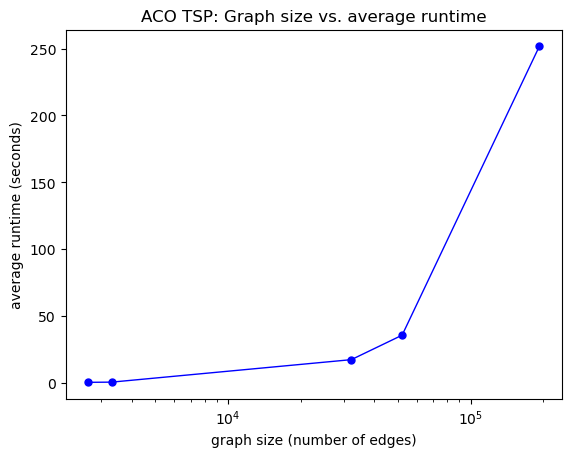

In [35]:
# Collect the graph sizes and average runtimes
sizes = [x.size() for x in list(results.keys())]
average_duration = [x[0] for x in list(results.values())]

# Plot the runtimes
plt.plot(sizes, average_duration, 'bo-', linewidth=1, markersize=5)
plt.xscale('log')
plt.xlabel('graph size (number of edges)')
plt.ylabel('average runtime (seconds)')
plt.title('ACO TSP: Graph size vs. average runtime')
plt.show()

#### Comments

The average runtime stays reasonable for smaller graphs, but quickly begins to grow with larger graphs. I would deduce that this is because the number of possible paths is not a linear function as you add edges - the difficulty of the problem increases quickly with more points to visit ways to get to those points.

## Question 3

### a) choose a dataset

I chose the [Openflights](https://networkrepository.com/inf-openflights.php) dataset, which shows flightpaths between certain airports. It has 2.9k nodes and 30.5k edges.

In [13]:
# Import the dataset
G = nx.read_edgelist('../inf-openflights.edges')

#### i) detect and visualize communities 

In [14]:
# I chose to use Clauset-Newman-Moore greedy modularity maximization
communities = nx.community.greedy_modularity_communities(G)

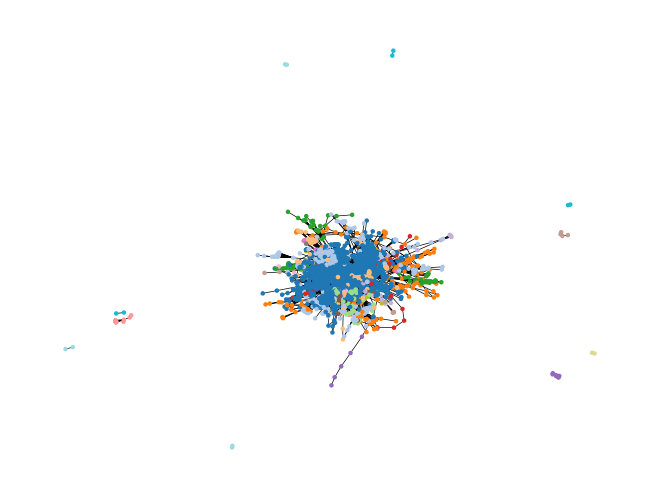

In [15]:
# Visualize the network

G_community_dict = {}
for i, community in enumerate(communities):
    for node in community:
        G_community_dict[node] = i

pos = nx.spring_layout(G)

colors = [G_community_dict[node] for node in G.nodes]

# Draw nodes with color based on community
nx.draw(G, pos, node_color=colors, cmap=plt.cm.tab20, node_size=5, width=0.5)

#### ii) report the modularity

In [16]:
# Find modularity
print('Modularity: ' + str(nx.community.modularity(G, communities)))

Modularity: 0.5763241304374902


#### iii) report the number of communities

In [17]:
# Find number of communities
print('Number of communities: ' + str(len(communities)))

Number of communities: 60


#### iv) store partition as a dictionary (already done in (i))

In [18]:
# Store partition as a dictionary
print('G_community_dict info:')
print('  Number of unique keys ' + str(len(G_community_dict)))
print('  Number of communities ' + str(len(communities)))

G_community_dict info:
  Number of unique keys 2939
  Number of communities 60


### b) graph-tool

Before executing the code for this question, make sure you are using the `/courses/PHYS7332.202510/shared/graphtool/` custom environment.

In [19]:
import graph_tool.all as gt

In [20]:
# Convert nx graph to graph-tool graph
G_gt = gt.Graph(directed=False)
for u, v in G.edges():
    e = G_gt.add_edge(u, v)

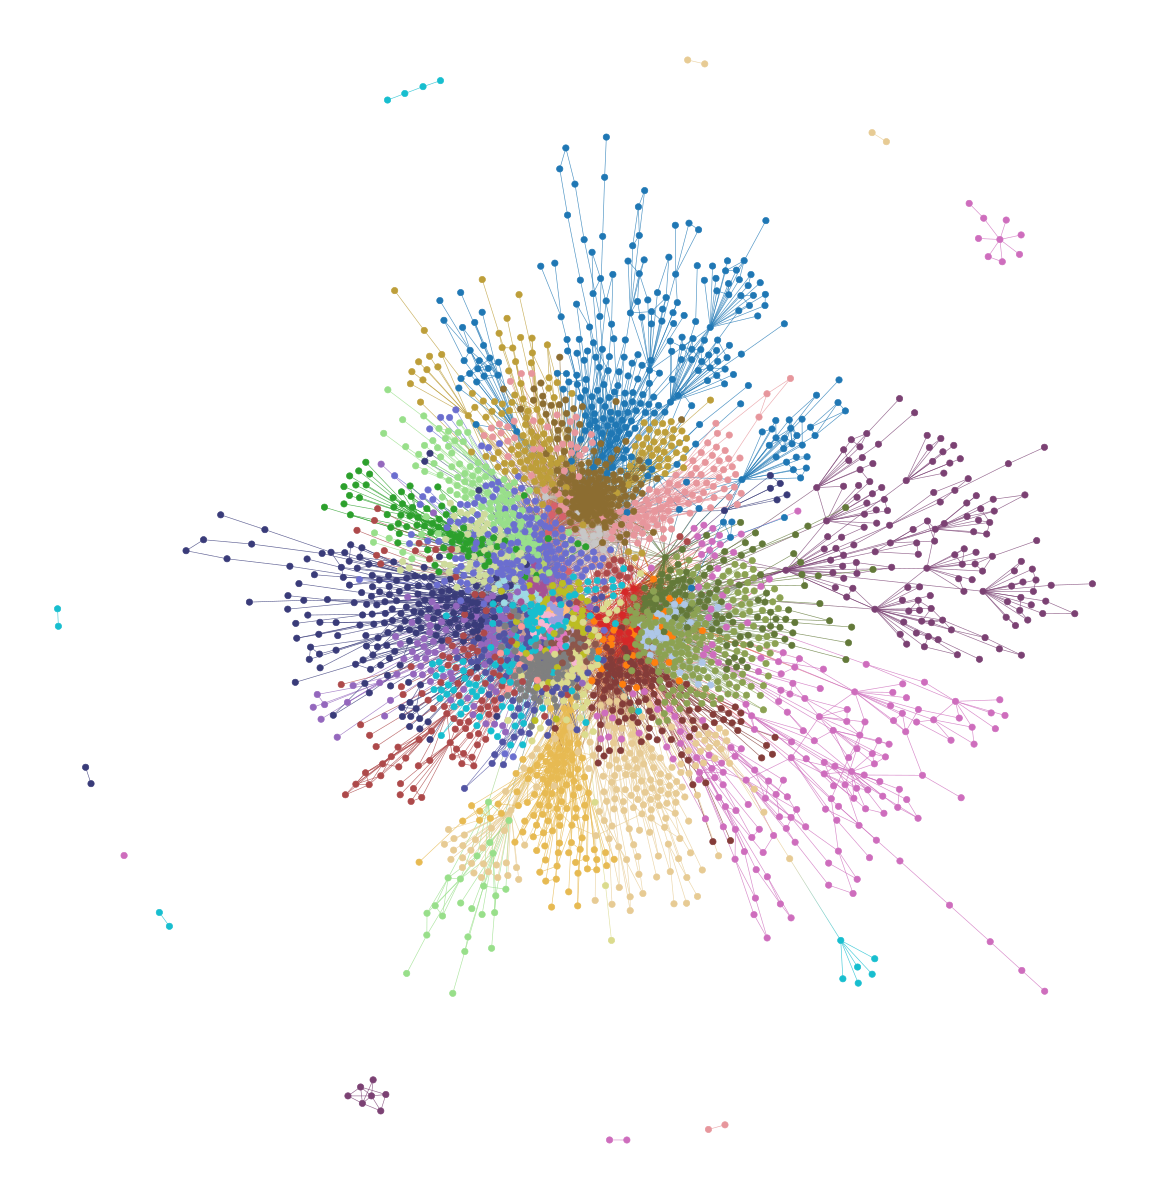

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x2b2b3d763260, at 0x2b2b3d387950>

In [21]:
# Detect communities
gt_partition = gt.minimize_blockmodel_dl(G_gt)

# Visualize the network
gt_partition.draw()

In [22]:
# Store partition as a dictionary

blocks = gt_partition.get_blocks() # get a mapping of the communities

# re-label the communities from 0..num_communities - 1
unique_blocks = np.unique(list(blocks))
block_mapping = {old_block: new_block for new_block, old_block in enumerate(unique_blocks)}


gt_community_dict = {v: block_mapping[b] for v, b in enumerate(blocks)}
print('G_community_dict info:')
print('  Number of unique keys ' + str(len(gt_community_dict)))
print('  Number of communities ' + str(len(unique_blocks)))

G_community_dict info:
  Number of unique keys 2940
  Number of communities 39


### c) randomize the network

In [23]:
# Create a null model by randomly swapping edges while preserving degrees
G_null = nx.double_edge_swap(G, nswap=G.number_of_edges(), max_tries=200000)

# Convert nx graph to graph-tool graph
G_gt_null = gt.Graph(directed=False)
for u, v in G_null.edges():
    e = G_gt_null.add_edge(u, v)

In [24]:
# Clauset-Newman-Moore modularity maximization
G_null_communities = nx.community.greedy_modularity_communities(G_null)

# Store partition as a dictionary
G_null_community_dict = {}
for i, community in enumerate(G_null_communities):
    for node in community:
        G_null_community_dict[node] = i
        
print('G_null_community_dict info:')
print('  Number of unique keys ' + str(len(G_null_community_dict)))
print('  Number of communities ' + str(len(G_null_communities)))

G_null_community_dict info:
  Number of unique keys 2939
  Number of communities 49


In [26]:
# graph-tool comminitiy detection
null_partition = gt.minimize_blockmodel_dl(G_gt_null)

# Store partition as a dictionary
blocks = null_partition.get_blocks() # get a mapping of the communities

# re-label the communities from 0..num_communities - 1
unique_blocks = np.unique(list(blocks))
block_mapping = {old_block: new_block for new_block, old_block in enumerate(unique_blocks)}

gt_null_community_dict = {v: block_mapping[b] for v, b in enumerate(blocks)}

print('gt_null_community_dict info:')
print('  Number of unique keys ' + str(len(gt_null_community_dict)))
print('  Number of communities ' + str(len(unique_blocks)))

gt_null_community_dict info:
  Number of unique keys 2940
  Number of communities 1


### d) discussion

After looking into some different techniques for comparing communitiy partitions in graphs, I found a lot on normalized mutual information (NMI). Basically, it is a technique for comparing the community structures found by one method and the structures found by another method. At a high level, NMI compares the amount of information shared between two variables, and determines how much one can learn about one variable by learning about the other.  The higher the NMI, the more similar the partitions are. I also chose the normalized version of this technique, which allows for comparison between graphs with different numbers of communities. So, the function *f*, if applying this technique, would return a value between 0 and 1 that represents the amount of information that can be gleaned about *b<sub>2</sub>* by learning about *b<sub>1</sub>*.